In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf

import calendar
import time
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [151]:
plt.rcParams["figure.figsize"] = (15, 8)

# sns.set(style='whitegrid', palette="bright")
sns.set_theme()
sns.set(font_scale = 1.25)

FONT_SIZE=14

## Data Load

In [2]:
sales_train_val = pd.read_csv('./data/m5-forecasting-accuracy/sales_train_validation.csv')

In [3]:
calendar = pd.read_csv('./data/m5-forecasting-accuracy/calendar.csv')

In [22]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [38]:
calendar[['date', 'd']].head()

,date,d
0,2011-01-29,d_1
1,2011-01-30,d_2
2,2011-01-31,d_3
3,2011-02-01,d_4
4,2011-02-02,d_5


## Let's pick particular product to observe

In [35]:
sales_train_val.filter(regex='d_').T.median().argmax()

8412

In [52]:
pd.Series(sales_train_val.loc[8412])

id          FOODS_3_090_CA_3_validation
item_id                     FOODS_3_090
dept_id                         FOODS_3
cat_id                            FOODS
store_id                           CA_3
                       ...             
d_1909                               88
d_1910                               77
d_1911                              141
d_1912                              139
d_1913                              130
Name: 8412, Length: 1919, dtype: object

In [4]:
product_data = sales_train_val[sales_train_val.id == 'FOODS_3_090_CA_3_validation']

In [5]:
product_data = product_data.filter(regex='d_').T.rename(columns={8412: 'FOODS_3_090_cnt'})

In [6]:
product_data = (pd.merge(calendar[['date', 'd']], product_data, 
         left_on='d', right_on = product_data.index, how='left')
     .drop(columns='d'))

In [7]:
product_data['date'] = pd.to_datetime(product_data['date'])
product_data_by_time = product_data.set_index(keys='date')

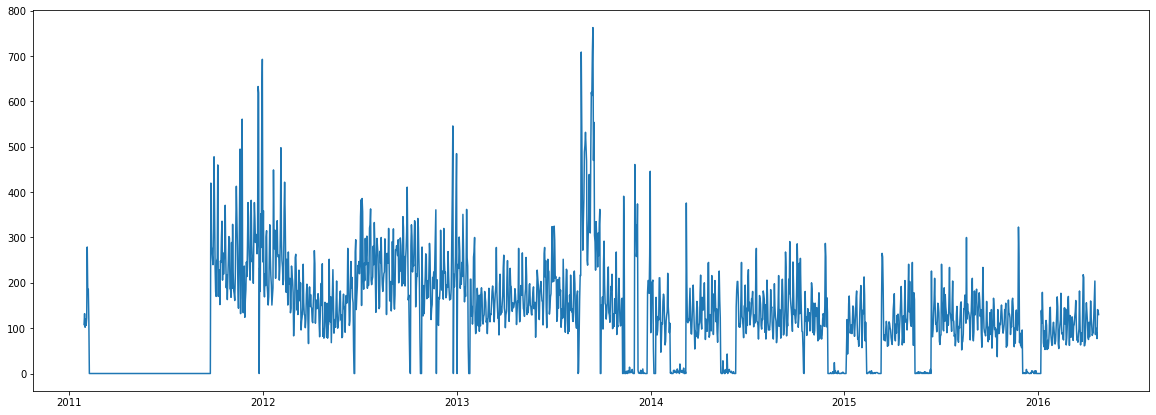

In [86]:
plt.figure(figsize=(20, 7))
plt.plot(product_data_by_time)

In [91]:
product_data_by_time.dropna()

,FOODS_3_090_cnt
date,
2011-01-29,108.0
2011-01-30,132.0
2011-01-31,102.0
2011-02-01,120.0
2011-02-02,106.0
...,...
2016-04-20,88.0
2016-04-21,77.0
2016-04-22,141.0


In [94]:
calendar[calendar.date == '2016-04-24']

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1912,2016-04-24,11613,Sunday,2,4,2016,d_1913,NaN,NaN,NaN,NaN,0,0,0


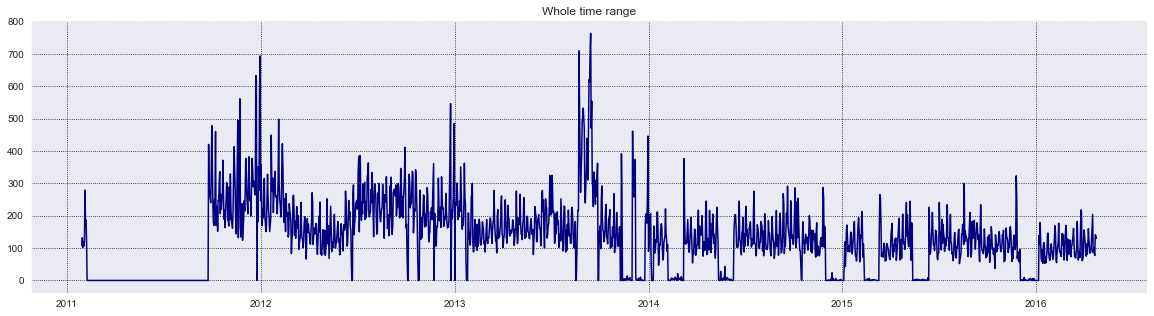

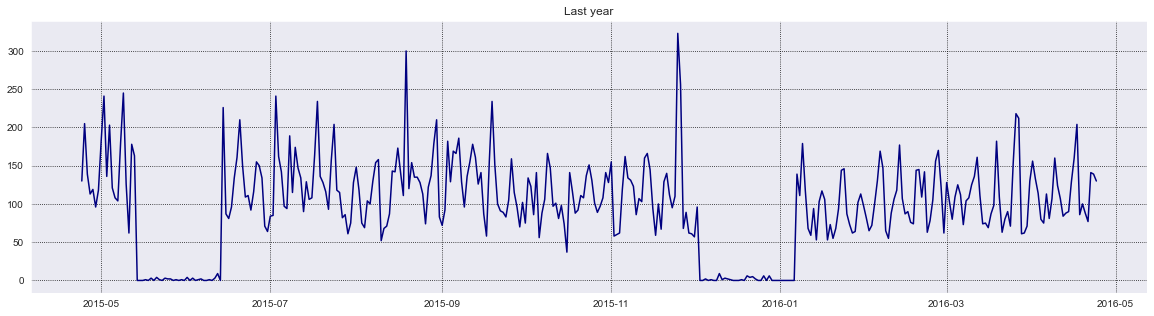

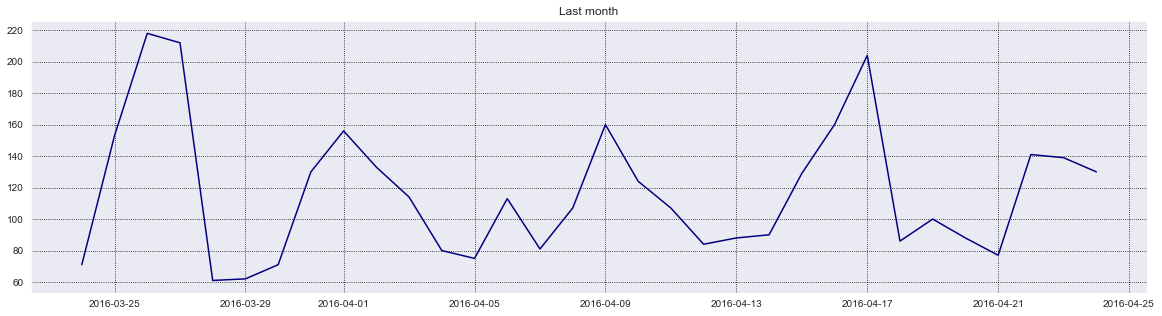

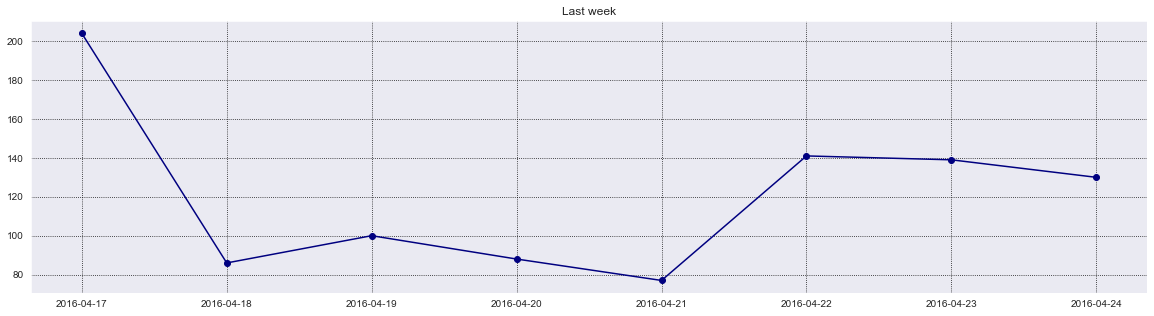

In [96]:
sns.set_style('darkgrid')
plt.figure(figsize=(20, 5))
plt.plot(product_data_by_time['FOODS_3_090_cnt'], color='navy')
plt.title('Whole time range')
plt.grid(linestyle=':', color='k')
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(product_data_by_time.loc['2015-04-24':, 'FOODS_3_090_cnt'], color='navy')
plt.title('Last year')
plt.grid(linestyle=':', color='k')
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(product_data_by_time.loc['2016-03-24':, 'FOODS_3_090_cnt'], color='navy')
plt.title('Last month')
plt.grid(linestyle=':', color='k')
plt.show()

plt.figure(figsize=(20, 5));
plt.plot(product_data_by_time.loc['2016-04-17':, 'FOODS_3_090_cnt'], '-o', color='navy')
plt.title('Last week')
plt.grid(linestyle=':', color='k')
plt.show()

**Okay, looks like there's definitely some weekly p-periodicity**

In [98]:
product_data_by_time

,FOODS_3_090_cnt
date,
2011-01-29,108.0
2011-01-30,132.0
2011-01-31,102.0
2011-02-01,120.0
2011-02-02,106.0
...,...
2016-06-15,NaN
2016-06-16,NaN
2016-06-17,NaN


In [107]:
dayweek_map_dict = {dayweek: index for index, dayweek in enumerate(calendar.day_abbr) if dayweek}
dayweek_map_dict = dict(zip(dayweek_map_dict.values(), dayweek_map_dict.keys()))
dayweek_map_dict

{0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

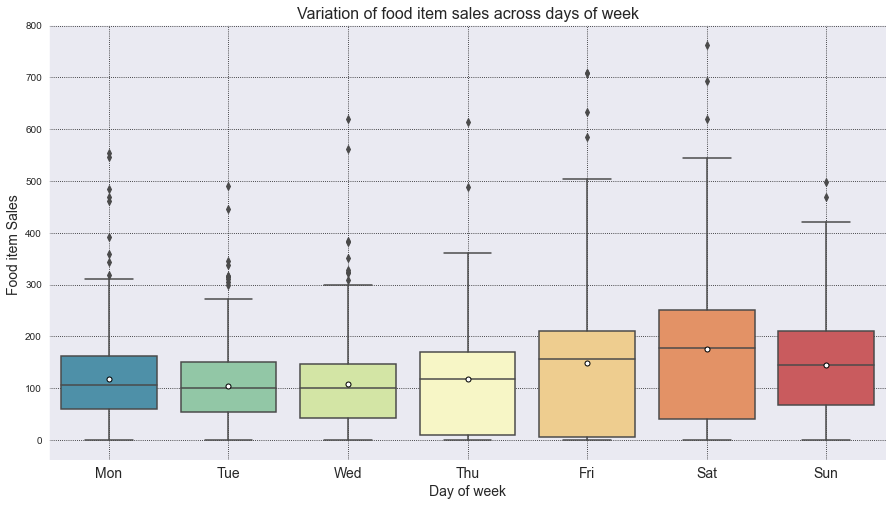

In [108]:
plt.subplots(1, 1, figsize=(15, 8))
sns.boxplot(data=product_data_by_time, x=product_data_by_time.index.dayofweek, y='FOODS_3_090_cnt', 
            palette = "Spectral_r", showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"5"});
plt.ylabel(ylabel='Food item Sales ', size=14)
plt.xlabel(xlabel='Day of week', size=14)
plt.xticks(np.arange(7), dayweek_map_dict.values(), fontsize=14)
plt.grid(linestyle=':')
plt.title('Variation of food item sales across days of week', fontsize=16)
plt.grid(linestyle=':', color='k')
plt.show()

In [109]:
month_map_dict = {month: index for index, month in enumerate(calendar.month_abbr) if month}
month_map_dict = dict(zip(month_map_dict.values(), month_map_dict.keys()))
month_map_dict

{1: 'Jan',
 2: 'Feb',
 3: 'Mar',
 4: 'Apr',
 5: 'May',
 6: 'Jun',
 7: 'Jul',
 8: 'Aug',
 9: 'Sep',
 10: 'Oct',
 11: 'Nov',
 12: 'Dec'}

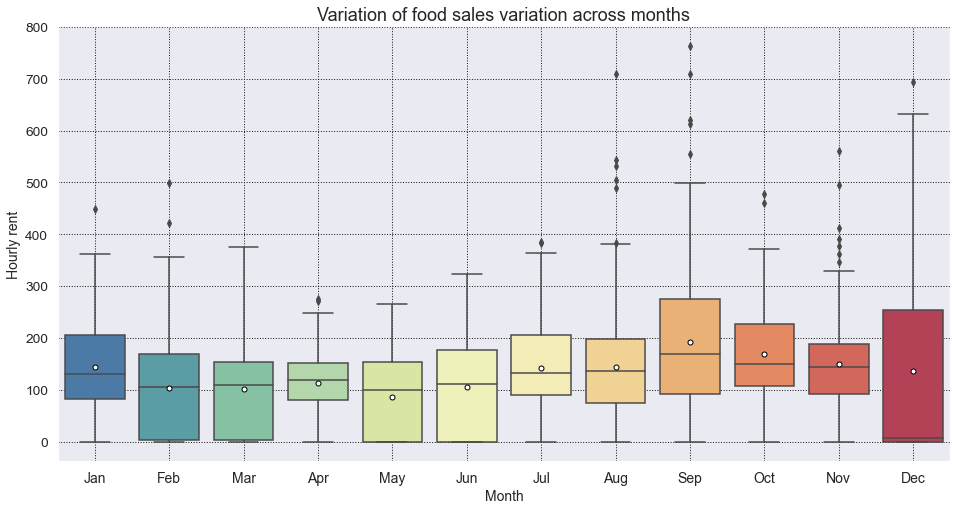

In [149]:
# Distribution of data by months
plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data=product_data_by_time, x=product_data_by_time.index.month, y='FOODS_3_090_cnt', 
            palette="Spectral_r", showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"5"})
plt.ylabel(ylabel='Hourly rent', size=14)
plt.xlabel(xlabel='Month', size=14)
plt.xticks(np.arange(12), 
           ['Jan', 'Feb', 'Mar', 
            'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 
            'Oct', 'Nov', 'Dec'],  
           size=14)
plt.title('Variation of food sales variation across months', fontsize=18)
plt.grid(linestyle=':', color='k')
plt.show()

In [116]:
month_prod_desc = product_data.groupby(product_data_by_time.index.month)['FOODS_3_090_cnt'].describe()
month_prod_desc.index = month_prod_desc.index.map(month_map_dict)

month_prod_desc.style.background_gradient(cmap=sns.color_palette("YlOrBr", as_cmap=True))

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
Jan,158.000000,143.765823,92.254575,0.000000,82.250000,129.500000,205.000000,449.000000
Feb,170.000000,103.588235,97.919638,0.000000,2.250000,105.000000,169.750000,498.000000
Mar,186.000000,101.790323,77.646420,0.000000,2.750000,110.000000,153.000000,376.000000
Apr,174.000000,112.344828,65.935742,0.000000,80.250000,118.500000,152.250000,276.000000
May,155.000000,85.064516,81.144466,0.000000,0.000000,100.000000,154.000000,266.000000
Jun,150.000000,105.820000,92.277745,0.000000,0.000000,110.500000,175.750000,324.000000
Jul,155.000000,141.019355,97.044472,0.000000,89.000000,132.000000,206.500000,386.000000
Aug,155.000000,143.470968,119.182078,0.000000,74.500000,136.000000,198.000000,709.000000
Sep,150.000000,191.420000,148.609857,0.000000,92.250000,169.000000,274.500000,763.000000


In [8]:
product_data_by_time

,FOODS_3_090_cnt
date,
2011-01-29,108.0
2011-01-30,132.0
2011-01-31,102.0
2011-02-01,120.0
2011-02-02,106.0
...,...
2016-06-15,NaN
2016-06-16,NaN
2016-06-17,NaN


In [9]:
alpha = 0.05
print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(product_data_by_time['FOODS_3_090_cnt'].dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < alpha:
    print("The process is stationary.\n")
else:
    print("The process is non-stationary.\n")  

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -4.1730181487191444
p-value: 0.0007317275745300164
The process is stationary.



In [11]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(product_data_by_time['FOODS_3_090_cnt'].dropna(), regression='c')
print("KPSS Statistic = " + str(kpsstest[0]))
print( "p-value = " +str(kpsstest[1]))
if kpsstest[1] < alpha:
    print("The process is non-stationary.\n")
else:
    print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.7981683609125003
p-value = 0.01
The process is non-stationary.



C:\Users\oleksii.kachmar\AppData\Local\Temp\ipykernel_19908\3342818466.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(product_data_by_time['FOODS_3_090_cnt'].dropna(), regression='c')


**These test provided us with controversial answers, But since one of them claims that process is non-stationary it will be better to consider the process as non-stationary one.**